In [22]:
import numpy as np
from numpy.random import default_rng
from scipy.integrate import odeint
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt

In [23]:
# Define classes
class Agent_gen():
    """Class of agents, holding opinion and being more or less active.
    Each agent shall act like a socially embedded human."""
    def __init__(self, name, opinion_0, activity_0):
        self.name = name
        self.x_i = opinion_0
        self.a_i = activity_0

class F_gen(rv_continuous):
    """Activitiy sampling distribution identical to Baumann et al.
    It models the intuitive assumption, that by far most people
    are hardly posting on social media, and even less people being
    very active. 
    

    For Reference, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous"""
    # define probability distribution as the paper's "F(a)"
    def _pdf(self, x):
        return ((1-gamma)/(1-epsilon**(1-gamma)))*x**(-1*gamma)


In [91]:
# Define methods

# Implement differential eq. 'dx/dt = [...]' as 'f(t) = [...]' 
def diffEq(x, t, alpha, K):
    sol = np.zeros(N)
    for i in range(N):
        sum_tmp = 0
        for j in range(N):
            sum_tmp = sum_tmp+A[i][j]*np.tanh(alpha*x[j])
        sol[i] = -x[i]+K*sum_tmp
    return sol

def p(i, j, beta):
    sum_tmp = 0
    for j_tmp in range(N):
        if x[i] != x[j_tmp]:
            sum_tmp = sum_tmp+abs(x[i]-x[j_tmp])**(-beta)
    return (abs(x[i]-x[j])**(-beta))/sum_tmp

def A_gen(beta):
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                A[i][j] = p(i,j, beta)
                random_value = rng.random()
                if  10*A[i][j] > rng.random():
                    A[i][j] = 1.
                else:
                    A[i][j] = 0

#    for i in range(N):
#        for j in range(N):
#            np.random.choice(numpy.arange(0,1), p=[1-A[i][j], A[i][j] ])
#            A[i][j] = choices([0,1], [1-A[i][j], A[i][j]])

    return A


In [92]:
# Define fixed parameters
tMax = 10
dt = 0.01
N = 100
K=3

# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[0]
beta_current = betas[0]

# Fixed activity-driving (AD) parameters
m = 10
epsilon = 0.01
gamma = 2.1
r = 0.5

# Initialise uniform random number generator
rng = default_rng()

# Initialise Agents with uniformly spaced opinions, F(a)-sampled activity
x = np.linspace(-1,1,N)
F_dist = F_gen(name='F_dist', a=epsilon)
a = F_dist.rvs(size=N)
agents = []
for i in range(N):
    name_tmp = 'agent-'+str(i)
    agents.append(name_tmp)
    agents[i] = Agent_gen(name_tmp, x[i], a[i])

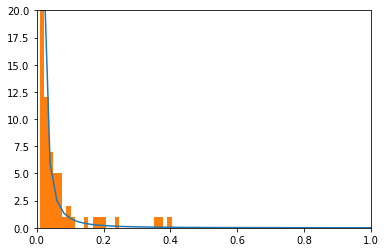

In [97]:
# Plot sampled activity distribution and analytical distribution

list_tmp = []
for i in range(N):
    list_tmp.append(agents[i].a_i)

a_plt = np.linspace(0,2,N)[1:]
F_plt = np.zeros(len(a_plt))
for i in range(len(F_plt)):
    F_plt[i] = ((1-gamma)/(1-epsilon**(1-gamma)))*a_plt[i]**(-1*gamma)

plt.clf()
plt.plot(a_plt, F_plt)
plt.hist(list_tmp, bins=30)

plt.xlim([0, 1])
plt.ylim([0, 20])
plt.show()

In [94]:
# TODO:
# Runge-Kutta 4
# Berechne A als int(m*p*rng.random(1)>1)


In [ ]:
# Runge-Kutta 4 Implementation
t_current = 0
while t_current < tMax:
    t_RK4 = np.linspace(t_current, t_current+dt, 2)
    A = A_gen(beta_current)
    solODE = odeint(diffEq, x, t_RK4, args=(alpha_current, K))
    t_current = t_current + dt
    # Append second column of solODE, as first one is filled with starting values
    xneu = np.vstack([xneu, solODE[1]])
    print(t_current)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
0.4100000000000002
0.4200000000000002
0.4300000000000002
0.4400000000000002
0.45000000000000023
0.46000000000000024
0.47000000000000025
0.48000000000000026
0.49000000000000027
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.60000